In [27]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import re
import numpy as np
train_folder = 'images/images/'

In [28]:
filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)

# remove all files that are not images
for filename in filenames:
    if not filename.endswith('.jpg'):
        filenames.remove(filename)

In [29]:


labels=[]
for filename in filenames:
    label = re.split('_', filename)
    if len(label) == 2:
        label = label[0]
    else:
        label = label[0]+"_"+label[1]
    labels.append(label)

# print unique labels
print(set(labels))

# count classes in labels
from collections import Counter
Counter(labels)


{'samoyed', 'wheaten_terrier', 'Abyssinian', 'miniature_pinscher', 'english_setter', 'english_cocker', 'havanese', 'american_pit', 'great_pyrenees', 'chihuahua', 'german_shorthaired', 'Russian_Blue', 'pomeranian', 'pug', 'Bombay', 'staffordshire_bull', 'japanese_chin', 'Persian', 'Birman', 'Sphynx', 'Egyptian_Mau', 'leonberger', 'keeshond', 'Ragdoll', 'beagle', 'Maine_Coon', 'Bengal', 'american_bulldog', 'Siamese', 'basset_hound', 'scottish_terrier', 'saint_bernard', 'British_Shorthair', 'boxer', 'shiba_inu', 'newfoundland', 'yorkshire_terrier'}


Counter({'Egyptian_Mau': 200,
         'pug': 200,
         'basset_hound': 200,
         'Siamese': 200,
         'shiba_inu': 200,
         'Birman': 200,
         'leonberger': 200,
         'saint_bernard': 200,
         'Abyssinian': 200,
         'miniature_pinscher': 200,
         'wheaten_terrier': 200,
         'scottish_terrier': 199,
         'pomeranian': 200,
         'german_shorthaired': 200,
         'english_setter': 200,
         'newfoundland': 200,
         'Sphynx': 200,
         'British_Shorthair': 200,
         'Bombay': 200,
         'boxer': 200,
         'great_pyrenees': 200,
         'samoyed': 200,
         'Russian_Blue': 200,
         'Persian': 200,
         'japanese_chin': 200,
         'Ragdoll': 200,
         'english_cocker': 200,
         'Maine_Coon': 200,
         'havanese': 200,
         'Bengal': 200,
         'american_pit': 200,
         'keeshond': 200,
         'american_bulldog': 200,
         'chihuahua': 200,
         'beagle': 200,
  

In [30]:
classes = list(set(labels))
classes_idx= {classes[i]: i for i in range(len(classes))}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


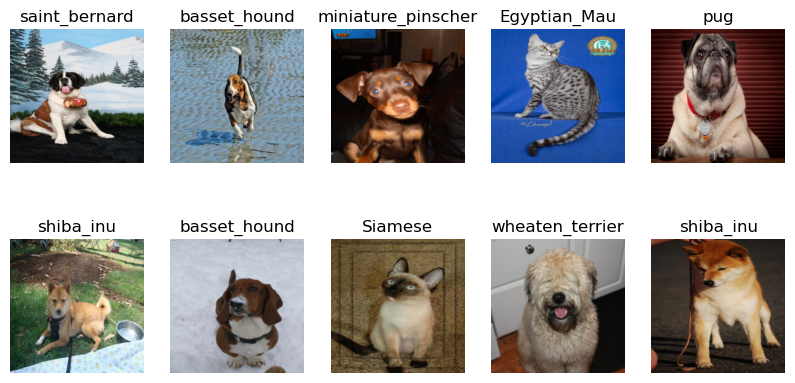

In [31]:
class PetDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        try:
            image = Image.open(train_folder+self.filenames[idx])
            image = image.convert('RGB')
            label = classes_idx[self.labels[idx]]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(e)
            print("Error loading image: ", self.filenames[idx], "idx", idx)

transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224), antialias=True),
])

sample_dataset=PetDataset(filenames[:20], labels[:20], transform=transform)
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
index=0
for xb, yb in sample_dataloader:
    for row in range(2):
        for col in range(5):
            ax[row, col].imshow(xb[row*5+col].permute(1, 2, 0))
            ax[row, col].set_title(classes[yb[row*5+col].item()])
            ax[row, col].axis('off')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [33]:
class OxfordPetsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.layer1=torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(p)
        )
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p)
        )
        self.layer3=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p)
        )

        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(256*3*3, 300),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(300)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(300, 37),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, xb):
        out=self.layer1(xb)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

model=OxfordPetsModel()
model(xb).shape

torch.Size([10, 37])

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [35]:
def get_accuracy(model, loader):
    correct=0
    for xb, yb in loader:
        xb=xb.to(device)
        yb=yb.to(device)
        y_hat=model(xb)
        y_pred=torch.argmax(y_hat, dim=1)
        correct+=(y_pred==yb).sum().item()
    return correct/len(loader.dataset)

In [36]:
batch_size=128

train_dataset=PetDataset(X_train, y_train, transform=transform)
test_dataset=PetDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [37]:
lr=0.01

loss_fn = nn.CrossEntropyLoss()

def train_batch(model,optimizer,  xb, yb):
    xb=xb.to(device)
    yb=yb.to(device)
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    preds=torch.argmax(y_hat, dim=1)
    return loss.item(), (preds==yb).sum().item()/len(yb)

def train_epoch(model, optimizer,  x, y):
    losses=[]
    accs=[]
    for xb, yb in train_loader:
        loss, acc=train_batch(model, optimizer, xb, yb)
        losses.append(loss)
        accs.append(acc)
    return losses, np.mean(accs), get_accuracy(model, test_loader)


  0%|          | 0/20 [00:00<?, ?it/s]

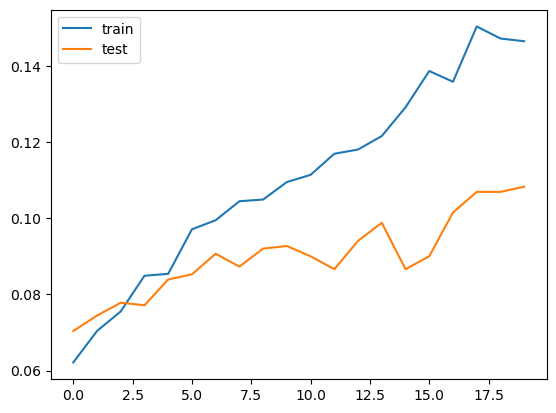

In [38]:
model = OxfordPetsModel().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

EPOCHS=20
train_accs=[]
test_accs=[]
# define tqdm bar
bar=tqdm(range(EPOCHS))
for i in bar:
    losses, train_acc, test_acc=train_epoch(model, optimizer, X_train, y_train)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    bar.set_description(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()
plt.show()

# Overfitting
wir sehen ein Overfitting ab Epoche 5. Was könnte man dagegen tun?

* mehr Daten
* weight decay bei adam
* image augmentation
* dropout erhöhen
* Modelkomplexität verrringern